# Model Preparation and Processing

Now that our data is usable for our model, we can start
going through the steps to make the first set of
models.

In this notebook, we'll make preliminary and final
models for our predictions. We'll convert our data from
the original data set's final structure into a form we
can train our models on. Rather than having a series of
raw text that we would generally be able to read, we
want our model to receive vectorized data. This applies
to several other features as well, which we will
address as they come up.

## Imports

Many of the imports from the first notebook are used
again alongside several additional packages.

Because the previous notebook is dedicated to the major
preprocessing steps and because that same notebook was
used to create a simplified form of our original data
structures, we'll be using that data as our starting
point. Since that file is much smaller, it has been
provided in the data/ folder in this project's
repository. It can also be recreated from the processes
outlined in
[the previous notebook](./1_Data_Prep.ipynb).

As before, required packages are defined in the yaml
file in the _code/ folder in this repository.

In [1]:
import numpy as np
import polars as pl
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, \
            GradientBoostingRegressor
from sklearn.model_selection import train_test_split, \
            cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer

from joblib import parallel_backend, Parallel, \
            dump, load

from _code.cleaner import preprocess

from IPython.display import Image, Markdown
sns.set()

As mentioned, we'll import our previously-created data
set rather than any of the raw data sets we used
initially.

In [2]:
cards = pd.read_parquet('./data/simplified_cards.parquet')

## Data Engineering

While we have pretty much all of the data we need from
the previous notebook, we can still benefit from having
several other pieces of information that can be
extracted from the data. One thing that we want to
modify is the way our abilities are stored.

### Processing Abilities/Oracle Text

Our abilities are currently stored as one string per
card. While this is useful in reading our abilities,
there is an important thing to note - a card can have
multiple abilities, as denoted by new lines on cards,
or a `\n` in the oracle text.

Since these abilities are mostly independent of one
another, we don't want them to be pushed together when
we convert them into vectorized versions of themselves.
A card with "Flying" and "When CARDNAME enters the
battlefield" shouldn't be read as "Flying when CARDNAME
enters the battlefield," they aren't part of the same
ability.

To get around this, we'll split each card's Oracle text
into an array at each `\n` and we can vectorize the
text from there.

Let's go ahead and look at the before and after of some
of our cards.

First, we'll generate our `processed_abilities` by
sending the Oracle text through our custom `preprocess`
function, which takes every ability we send it and
breaks it out into individual words, reducing them to
their root words, removing stop words, and then putting
them all back together for us.

After that, we'll separate of the returned abilities
into a list of abilities as described by splitting on
`\n`.

Once we finish that, we'll create a new column that is
a count of the total number of a given card has, as
cards that have more abilities are likely to have more
complexities or power and will, by extension, hold more
value. In theory at least.

In [3]:
display(
    cards[[
        'name','oracle_text',
        'median_normal','median_foil'
        ]].head()
)

processed_abilities = preprocess(cards['oracle_text'])
cards['abilities_list'] = [
    abilities.split('\n') 
    for abilities in processed_abilities
    ]

cards['n_abilities'] = cards['abilities_list'].map(len)

display(
    cards[[
        'name','abilities_list',
        'median_normal','median_foil',
        'n_abilities'
        ]].head()
)


,name,oracle_text,median_normal,median_foil
0,Fury Sliver,All Sliver creatures have double strike.,0.380,3.95
1,Kor Outfitter,"When CARDNAME enters the battlefield, you may ...",0.240,7.78
2,Siren Lookout,"Flying\nWhen CARDNAME enters the battlefield, ...",0.060,0.23
3,Web,Enchant creature (Target a creature as you cas...,0.640,NaN
4,Venerable Knight,"When CARDNAME dies, put a +1/+1 counter on tar...",0.095,0.28


,name,abilities_list,median_normal,median_foil,n_abilities
0,Fury Sliver,[sliver creature double strike],0.380,3.95,1
1,Kor Outfitter,[cardname enters battlefield may attach target...,0.240,7.78,1
2,Siren Lookout,"[fly , cardname enters battlefield explores ]",0.060,0.23,2
3,Web,"[enchant creature , enchant creature get +0/...",0.640,NaN,2
4,Venerable Knight,[cardname die put +1/+1 counter target knight ...,0.095,0.28,1


## Model Preparation

Now that we have our data ready for our modeling steps,
we can go ahead and do our splits for our training and
testing subsets. As mentioned before, we'll be making
sure that our training and testing data have cards from
different sets at similar rates.

We'll also go ahead and get rid of the original
`prices_` columns, as we're only going to focus on the
median prices for this project.

In [4]:
X = cards.drop(columns=['prices_normal','prices_foil'])
y = cards['set']
train, test, _, _ = \
    train_test_split(
        X,y,stratify=y,
        random_state=13,
        test_size=0.2
    )

# we'll reset the indices of both sets to more easily
# translate between polars and pandas in an upcoming
# step

train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

# printing out value counts to demonstrate that the
# splits are even 

display(
    train['set'].value_counts(normalize=True)[:5],
    test['set'].value_counts(normalize=True)[:5]
)

set
mb1      0.027116
plist    0.016935
clb      0.014430
sld      0.013749
j22      0.013388
Name: proportion, dtype: float64

set
mb1      0.027096
plist    0.016995
clb      0.014430
sld      0.013789
j22      0.013388
Name: proportion, dtype: float64

### Ability Vectorization

In order to train a model on our data, we need to have
a feature/column for each word or phrase we want to
target. We'll use the Count Vectorizer provided by
SKlearn to do this.

In [5]:
# Our token pattern needs to be able to account for
# several non-standard things for it to be effective
# for our needs. As normal, it needs to be able to
# match words that are contiguous letters of an
# arbitrary length. However, we also need to be able to
# account for numbers in a few formats. These can be
# wrapped in curly brackets, e.g. {2}, representing 2
# colorless mana.
# It also needs to be able to account for letters
# inside of curly brackets and return them as such.
# It must also match something like +1/+1, -1/-1, or
# several other variations thereof.
# Lastly, it should also ignore any text that is inside
# of parentheses, as this text is reminder text - which
# is text that explains what an ability does but this
# text doesn't actually contribute to explaining what
# a card does in a meaningful way. 

token_pattern = \
    r"([a-zA-Z]+(?:’[a-z]+)?|[+-]?\d\/[+-]?\d|\{\d\d?\}|\{.\s?.?\}|\n)|\(.+?\)"

cvec = CountVectorizer(
        token_pattern=token_pattern,
        # min_df=0.0005, # <= this will mean that the
                    # minimum number of cards that it
                    # takes for an ability to show up
                    # on this list will be 46 after the
                    # explode is run, since it will be
                    # 83,000 entries long. We'll just
                    # limit our overall features since
                    # this is such a small percentage. 
        max_df=0.4,
        ngram_range=(1,5),
        max_features=1500
    )

Currently, our abilities are listed out as lists or
arrays, but the vectorizer needs them as strings rather
than a list of strings. To effectively accomplish this,
we'll need to explode our data frame. This will make
each card have a duplicate entry for each ability it
has, so cards that have 3 or 4 abilities will instead
have 3 or 4 entries with 1 ability each. Because of
this, our data frame will be substantially larger. We
won't be able to reliably use a minimum document
frequency in our vectorizer, but that's okay.

In [6]:
display(train[['name','abilities_list']].head())
explode_train = train.explode('abilities_list')
display(explode_train[['name','abilities_list']].head())

,name,abilities_list
0,Stolen Identity,"[create token copy target artifact creature , ..."
1,Ageless Entity,[whenever gain life put many +1/+1 counter car...
2,Izzet Locket,"[{t} add {u} {r} , u r u r u r u r {t} sacrif..."
3,Inspired Charge,[creature control get +2/+1 end turn]
4,"Oros, the Avenger","[fly , whenever cardname deal combat damage p..."


,name,abilities_list
0,Stolen Identity,create token copy target artifact creature
0,Stolen Identity,cipher
1,Ageless Entity,whenever gain life put many +1/+1 counter card...
2,Izzet Locket,{t} add {u} {r}
2,Izzet Locket,u r u r u r u r {t} sacrifice cardname draw t...


Now we can perform our vectorization.

In [7]:
explode_vec = cvec.fit_transform(
        explode_train['abilities_list']
    )
explode_vec = pd.DataFrame.sparse.from_spmatrix(
    explode_vec
)

# we save the vocab here to export for later. This is
# so we can bring in new data and make sure it's only
# being segmented into vocab we can "understand"
explode_vec.columns = sorted((vocab := cvec.vocabulary_))
explode_vec['id'] = explode_train['id'].values
explode_vec.head()

,+1/+0,+1/+0 end,+1/+0 end turn,+1/+1,+1/+1 counter,+1/+1 counter cardname,+1/+1 counter creature,+1/+1 counter creature control,+1/+1 counter target,+1/+1 counter target creature,...,{u} {t},{u} {u},{w},{w} cardname,{w} {b},{w} {t},{w} {u},{w} {w},{x},id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5


Let's take a look at the number of total entries versus
the number of unique cards in our data set.

In [8]:
explode_vec['id'].nunique(),explode_vec.shape[0]

(49896, 88164)

It looks like we have a little bit under 2 abilities
per card, which makes sense considering most cards have
1 ability.

For this next step, we'll convert the data frame we
have from a Pandas data frame into a Polars data frame.
The rest of the processes afterwards will take place in
Pandas, but Polars is able to much more efficiently
handle group-by operations, and we need to have a sum
of each individual word for each unique card.

In [9]:
# convert pandas vectorized dataframe to polars
pl_vec = pl.from_pandas(explode_vec.astype(np.int32,errors='ignore'))
# perform group by and sum aggregation and convert back
# to pandas 
agged_vec = pl_vec.groupby('id').sum().to_pandas()

agged_vec.shape

(49896, 1501)

Great. Now we have our data frame back to on entry per
card. We'll keep this data frame to the side for now so
that we can merge it back in later. There are a couple
more vectorizations that need to take place.

### Type Line Vectorization

A much simpler type of categorization for cards is the
type that a card is. Creatures and enchantments are
cast differently, have different drawbacks and
benefits, and sometimes are both on the same card. We
can capture a lot of information just in observing a
card's types and super types. For now, we'll ignore
subtypes because there is a lot more nuance in those
and they generally don't change much of how a card
works. There are a few exceptions but even then they're
minor.

We'll do much of the same process by vectorizing our
types through a count vectorizer, effectively one hot
encoding our data but in a little bit simpler of a
process. We don't need any special patterns or limits
here because the card types are all single words.

The only pre-processing we need to do on this subset of
information is to separate a card's types from its
subtypes. On Magic cards, a card's type line is
divided into its types (and supertypes) and subtypes by
an emdash (—). Since this is a lambda apply process,
we actually want to use polars to handle this process
more efficiently. Then we can give it an ID column and
set it aside just like we did with the Oracle text
before.

In [10]:
card_type_cvec = CountVectorizer()

type_frame = pl.from_pandas(train['type_line']).apply(lambda x: x.split('—')[0])
type_df = pd.DataFrame.sparse.from_spmatrix(
    card_type_cvec.fit_transform(type_frame)
)
# we save the type vocab for later to export
type_df.columns = sorted((type_vocab:=card_type_cvec.vocabulary_))
type_df['id'] = train['id']
display(type_df.head(),type_df.shape)

,artifact,basic,conspiracy,creature,enchantment,instant,land,legendary,planeswalker,snow,sorcery,stickers,tribal,world,id
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,98151986-90de-4f76-9abd-507039e7c9ad
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,c2790685-f6ae-4106-ae4d-fe97954bcb82


(49896, 15)

This actually shows us that there are a couple of cards
that have types that we aren't interested in capturing
still. Sticker cards and Conspiracy cards make up very
specific portions of sets. They only exist in one and
two sets respectively. They have very unique abilities
that generally don't fall very well in line with the
rest of Magic as a whole. We'll want to keep this in
mind later when we bring all of this back together.

### Color Identity Vectorization

A feature that holds a lot of importance for a group of
people that have a lot of influence on the market is
color identity. The Commander format is one of the most
played formats in Magic and a card's ability to slot
into specific commander decks can be a huge indicator
for whether or not it's usable in the format.

The color identity is already split into a list for us
in our data set, so we can just merge those lists into
strings and run another count vectorizer that only
looks for single letters to vectorize on.

One thing to keep in mind - is that a card without a
color identity is considered colorless. This has its
own unique properties in Magic, so instead of just
treating it as a card that has none of the other
properties, we want to treat it as a card that
specifically is colorless.

Just like before, we'll give our data frame an ID
column to merge with later.

In [11]:
display(train[['color_identity']].head())

train['str_color_identity'] = \
    train['color_identity'].map(
        lambda x: ' '.join(x)
        )

display(train[['str_color_identity']].head())

color_match = CountVectorizer(
    token_pattern=r"[wubrg]"
)
color_id_df = pd.DataFrame.sparse.from_spmatrix(
    color_match.fit_transform(train['str_color_identity'])
)
color_id_df.columns = sorted(
        (color_vocab:=color_match.vocabulary_)
    )
color_id_df['c'] = color_id_df.T.apply(lambda x: 1 if sum(x)==0 else 0)
color_id_df['id'] = train['id']

display(color_id_df.head())

,color_identity
0,[U]
1,[G]
2,"[R, U]"
3,[W]
4,"[B, R, W]"


,str_color_identity
0,U
1,G
2,R U
3,W
4,B R W


,b,g,r,u,w,c,id
0,0,0,0,1,0,0,2831fe77-ea98-4334-a78e-01580fb002c0
1,0,1,0,0,0,0,f2d9b77b-d775-4546-91c8-df438a1d8dbe
2,0,0,1,1,0,0,a32ecc71-b924-4414-94ee-c6cb0ba752e5
3,0,0,0,0,1,0,98151986-90de-4f76-9abd-507039e7c9ad
4,1,0,1,0,1,0,c2790685-f6ae-4106-ae4d-fe97954bcb82


### Pseudo-Number Vectorization

Something interesting about some of the features we
have is that, at first glance, they appear to be
numbers. Features like power, toughness, and loyalty
all are (mostly) numbers, but there's a very major
distinction between having a 0 in one of these
categories and having a None in them. Because of this,
we have to actually split the columns out into dummies.

While we're doing this step, we'll go ahead and break
out rarity into its own columns since those also have
to be encoded out.

In [12]:
train[['rarity','power','toughness','loyalty']].head()

,rarity,power,toughness,loyalty
0,rare,None,None,None
1,rare,4,4,None
2,common,None,None,None
3,common,None,None,None
4,rare,6,6,None


In [13]:
# using count vectorizer to allow us to save off
# vocabs for later 

dummy_vectorizer = CountVectorizer(
    token_pattern = r".*",
    stop_words=[''],
    lowercase=False
    )
dummy_dict = {}
dummy_vocab = {}
dummy_columns = ['rarity','power','toughness','loyalty']
for _col in dummy_columns:
    dummy_column = train[_col].T.apply(
        lambda x: '' if x == None else f'{_col}_{x}'
        )
    dummy_dict[_col] = pd.DataFrame.sparse.from_spmatrix(
        dummy_vectorizer.fit_transform(dummy_column)#.astype(str))
    )
    dummy_vocab[_col] = dummy_vectorizer.vocabulary_
    dummy_dict[_col].columns = sorted(dummy_vocab[_col])
    dummy_dict[_col]['id'] = train['id']

dummies = train[['id']]
for _col in dummy_columns:
    dummies = dummies.merge(
        dummy_dict[_col],
        on='id'
    )
dummies.head()

,id,rarity_common,rarity_mythic,rarity_rare,rarity_special,rarity_uncommon,power_*,power_-1,power_0,power_1,...,toughness_8,toughness_9,loyalty_0,loyalty_2,loyalty_3,loyalty_4,loyalty_5,loyalty_6,loyalty_7,loyalty_X
0,2831fe77-ea98-4334-a78e-01580fb002c0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,98151986-90de-4f76-9abd-507039e7c9ad,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before we go on to merging everything, let's make sure
that all of our data frames are the same size and that
we didn't miss anything as far as accidental creation.

In [14]:
print(
f"""Colors:     {
    color_id_df.shape[0]
}
Types:      {
    type_df.shape[0]
}
Abilities:  {
    agged_vec.shape[0]
}
Dummies:    {
    dummies.shape[0]
}
Everything: {
    train.shape[0]
}"""
)

Colors:     49896
Types:      49896
Abilities:  49896
Dummies:    49896
Everything: 49896


### Date Conversion

Several of our modeling methods aren't going to like
having our date as a string, so we'll convert this over
into the age of a card in days so we can get rid of the
`released_at` column in our next step.

In [15]:
_now = pd.Timestamp.today().floor('D')
train['card_age'] = train['released_at'].apply(lambda x: (_now - x).days)
display(_now,
    train[['released_at','card_age']].head())

Timestamp('2023-05-28 00:00:00')

,released_at,card_age
0,2022-04-29,394
1,2004-02-06,7051
2,2019-08-23,1374
3,2010-07-16,4699
4,2007-02-02,5959


## Additional Data Reduction

Now that we've converted a lot of data into other
types or forms, we'll take a look at what's in our base
data frame and then reduce it down to just the data we
want to look at currently. At this point, there are
still some features in our data set that we may want to
investigate at some point in the future, but now we
need to gear it even more specifically to the model we
intend to produce.

First, let's look at what is still here before we make
our last feature selection.

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49896 entries, 0 to 49895
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  49896 non-null  object        
 1   oracle_id           49896 non-null  object        
 2   name                49896 non-null  object        
 3   released_at         49896 non-null  datetime64[ns]
 4   image_uris          49896 non-null  object        
 5   mana_cost           49896 non-null  object        
 6   cmc                 49896 non-null  float64       
 7   type_line           49896 non-null  object        
 8   oracle_text         49896 non-null  object        
 9   power               24195 non-null  object        
 10  toughness           24195 non-null  object        
 11  colors              49896 non-null  object        
 12  color_identity      49896 non-null  object        
 13  keywords            49896 non-null  object    

A lot of these features may have a lot of things that
could be interesting, but we need to bring it down to
size for a more limited scope to get some initial
models out.

In [17]:
used_columns = [
    'id',
    # 'oracle_id',
    # 'tcgplayer_id',
    # 'name',
    # 'released_at',  # This has been converted to card age
    # 'image_uris',
    # 'mana_cost',    # may need additional processing.
                    # This isn't something we can
                    # effectively use at this point so
                    # we'll get rid of it now.                 
    'cmc',
    # 'type_line',    # this is already captured as types
    # 'oracle_text',  # this has already been extracted
                    # as abilities
    # 'power',        # vectorized above
    # 'toughness',    # vectorized above
    # 'colors',
    # 'color_identity', # already vectorized
    # 'keywords',     # <= part of the abilities we
                    # extracted, may be useful to look
                    # at at another point 
    # 'legalities',   # <= since we're only looking at
                    # prices for new cards in this
                    # exploration, we can ignore the
                    # legalities of cards for now. This
                    # may be a good thing to look at in
                    # next steps. 
    # 'reserved',
    # 'foil',         # Both foil and nonfoil are
    # 'nonfoil',      # captured in price data
    'promo',
    'reprint',
    # 'variation',
    # 'set_id',       # This section may be useful for
    # 'set',          # later iterations. Ignoring for
    # 'set_type',     # now.
    # 'rarity',       # vectorized above
    'full_art',
    'textless',
    # 'edhrec_rank',  # This may actually be a reall
                        # useful metric to look at, but it
                        # will have to come into play at a
                        # later time. 
    # 'related_uris',
    # 'promo_types',
    # 'loyalty',          # vectorized above
    # 'produced_mana',  # Unsure of the effectiveness
                        # of this, but it's worth
                        # looking into later
    # 'variation_of',
    # 'abilities_list',   # This has already been
                        # captured by our explode.
    'n_abilities',
    'median_normal',    # Need to keep targets
    'median_foil',
    'card_age'
]

In [18]:
train_reduced = train[used_columns].copy()
train_reduced.shape

(49896, 10)

## Bringing the Data Together

Now that we have all of the data we need to be
vectorized vectorized, we can put all of our data
together into a single large data frame that we can do
the actual modeling on.

Once we have everything together, we can drop all of
the Conspiracy cards and Sticker cards that we
mentioned earlier.

In [19]:
train_combined = train_reduced.merge(
    agged_vec,
    on='id'
).merge(
    type_df,
    on='id'
).merge(
    color_id_df,
    on='id'
).merge(
    dummies,
    on='id'
)

train_combined = train_combined[
    (train_combined[ 'stickers' ] == 0) &
    (train_combined['conspiracy'] == 0)
].drop(columns=['stickers','conspiracy']).copy()

display(train_combined.head(),
    train_combined.shape
)
train_combined.info()

,id,cmc,promo,reprint,full_art,textless,n_abilities,median_normal,median_foil,card_age,...,toughness_8,toughness_9,loyalty_0,loyalty_2,loyalty_3,loyalty_4,loyalty_5,loyalty_6,loyalty_7,loyalty_X
0,2831fe77-ea98-4334-a78e-01580fb002c0,6.0,False,True,False,False,2,0.21,NaN,394,...,0,0,0,0,0,0,0,0,0,0
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,5.0,False,False,False,False,1,0.26,1.79,7051,...,0,0,0,0,0,0,0,0,0,0
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,3.0,False,True,False,False,2,0.11,NaN,1374,...,0,0,0,0,0,0,0,0,0,0
3,98151986-90de-4f76-9abd-507039e7c9ad,4.0,False,False,False,False,1,0.05,NaN,4699,...,0,0,0,0,0,0,0,0,0,0
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,6.0,False,False,False,False,2,0.55,9.50,5959,...,0,0,0,0,0,0,0,0,0,0


(49835, 1585)

<class 'pandas.core.frame.DataFrame'>
Index: 49835 entries, 0 to 49895
Columns: 1585 entries, id to loyalty_X
dtypes: Sparse[int64, 0](74), bool(4), float64(3), int32(1500), int64(3), object(1)
memory usage: 290.8+ MB


### Subsetting the Data

Because we have two separate prices for foil and
non-foil cards/printings, we'll actually split our data
again down to two different data frames - one for the
normal cards and one for the foil cards. Then we can
perform our dummy model tests to create a baseline
evaluation.

In [20]:
train_norm = train_combined.dropna(
    subset=['median_normal']
    ).drop(columns=['median_foil']
    ).reset_index(drop=True)

train_foil = train_combined.dropna(
    subset=['median_foil']
    ).drop(columns=['median_normal']
    ).reset_index(drop=True)

norm_prices = train_norm['median_normal']
foil_prices = train_foil['median_foil']

print(f""" 
All Cards:     {train_combined.shape[0]}
Normal Cards:  {train_norm.shape[0]}
Foil Cards:    {train_foil.shape[0]}"""
)

 
All Cards:     49835
Normal Cards:  45326
Foil Cards:    31235


## Modeling

Now that our targets are defined, our data is split,
and everything is generally ready for us to put through
some models, we're ready to start our modeling process.

### The Dummy Model

In order to effectively gauge how much progress is made
on our final model, we need to have something to base
it on, and for that we can create our dummy model. For
this, our dummy model will predict our median prices
for every card as the same and we'll score it by its
root mean squared error, which will be the primary
metric that our model is scored on throughout the rest
of this process.

<!-- One thing that may be helpful to understand is that the
prices in our data set are fairly abnormal. It may be
useful to create a version of the models that accounts
for the prices raw and a version that looks at the
logged version of the prices. -->

In [21]:
dummy = DummyRegressor(strategy='median')
norm_guess = dummy.fit(
    train_norm,norm_prices
    ).predict(train_norm)
foil_guess = dummy.fit(
    train_foil,foil_prices
    ).predict(train_foil)

# we'll print and save the dummy rmse values for later
print(f"""
RMSE for Normal Prices: {(norm_base_rmse := mean_squared_error(
        norm_prices,norm_guess,
        squared=False
    )):.4f}
RMSE for Foil Prices:   {(foil_base_rmse := mean_squared_error(
        foil_prices,foil_guess,
        squared=False
    )):.4f}"""
)


RMSE for Normal Prices: 91.6135
RMSE for Foil Prices:   47.2789


### Creating the First Models

There are a few valid and useful ways that we can model
our data here. We'll stick with default values for now
with a few caveats.

Let's go ahead and define our model parameters and
perform a grid search across our model options to find
the best model at our disposal.

One thing that may be helpful to understand is that the
prices in our data set are fairly abnormal. It may be
useful to create a version of the models that accounts
for the prices raw and a version that looks at the
logged version of the prices.

Since the logged version is going to have an inherently
lower root mean squared error because the numbers are
lower, we'll have to do the grid search of the models
separately and then compare their actual, final
predictions afterwards.

# ==============================================
# MODELING STEP, REVISIT BEFORE FINAL SUBMISSION
# ==============================================

In [22]:
#######################################################
# This section commented our for usability. This is a #
# very long grid search that takes a lot of           #
# precessing time. To save on time and make this      #
# project more usable, models have been saved off to  #
# their own files. This code can be uncommented to    #
# reproduce the provided .pkl files and recreate them #
# but this can take the notebook from minutes to run  #
# up to several hours.                                #
#######################################################

# normal_rfr = RandomForestRegressor(
#     min_samples_leaf=15,n_jobs=-3,random_state=13
#     )
# normal_gbr  = GradientBoostingRegressor(random_state=13)
# normal_net = ElasticNetCV(
#     n_jobs=-3,random_state=13,
#     positive=True,l1_ratio=0.8
#     )

# model_params = {
#     'model' : [normal_rfr,normal_gbr,normal_net]
# }
# pipe = Pipeline(
#     steps=[
#         ('model',DummyRegressor())
#     ]
# )

# # Grid Search Processing

# # to_numpy() method used to prevent GridSearchCV from
# # throwing errors about sparse arrays on each cross-
# # validation 

# X = train_norm.drop(columns=['median_normal','id']).to_numpy()
# y = train_norm['median_normal'].to_numpy()

# norm_gs = GridSearchCV(
#     pipe,model_params,
#     scoring='neg_root_mean_squared_error',
#     verbose=10
# ).fit(
#     X,y
# )

# log_norm_gs = GridSearchCV(
#     pipe,model_params,
#     scoring='neg_root_mean_squared_error',
#     verbose=10
# ).fit(
#     X,np.log(y)
# )

# X = train_foil.drop(columns=['median_foil','id']).to_numpy()
# y = train_foil['median_foil'].to_numpy()

# foil_gs = GridSearchCV(
#     pipe,model_params,
#     scoring='neg_root_mean_squared_error',
#     verbose=10
# ).fit(
#     X,y
# )

# log_foil_gs = GridSearchCV(
#     pipe,model_params,
#     scoring='neg_root_mean_squared_error',
#     verbose=10
# ).fit(
#     X,np.log(y)
# )

# dump(norm_gs,'./pickles/norm_gs.pkl')
# dump(foil_gs,'./pickles/foil_gs.pkl')
# dump(log_norm_gs,'./pickles/log_norm_gs.pkl')
# dump(log_foil_gs,'./pickles/log_foil_gs.pkl')

# # suppress return output from dump()
# ''; 

## Model Testing and Visualization

Now that we've fit and searched our models, it's time
to see which of our forms works best for our
predictions and how each of them score against our
initial dummy model.

Since we have our files saved off in the last step,
we'll load them in here now for compatibility with
both the commented and uncommented versions of the
model fit process.

Once those are loaded in, we'll make some predictions
and put our prices in a data frame with their relevant
predictions so that we can more easily score
everything.

While we're at it, let's double check what our best
estimators are under the hood.

In [23]:
models = {
    'norm'    :load('./pickles/norm_gs.pkl'),
    'foil'    :load('./pickles/foil_gs.pkl'),
    'log_norm'    :load('./pickles/log_norm_gs.pkl'),
    'log_foil'    :load('./pickles/log_foil_gs.pkl'),
}

for name, model in models.items():
    print(f"{name} : {model.best_estimator_}")

scorers = {}

X = train_norm.drop(columns=['median_normal','id']).to_numpy()
y = train_norm['median_normal'].to_numpy()

scorers['norm'] = pd.DataFrame(
    {
        'id': train_norm['id'],
        'pred': models['norm'].predict(X),
        'log_pred': np.exp(models['log_norm'].predict(X)),
        'true': y
    }
)

X = train_foil.drop(columns=['median_foil','id']).to_numpy()
y = train_foil['median_foil'].to_numpy()

scorers['foil'] = pd.DataFrame(
    {
        'id': train_foil['id'],
        'pred': models['foil'].predict(X),
        'log_pred': np.exp(models['log_foil'].predict(X)),
        'true': y
    }
)

display(
    scorers['norm'].head(),
    scorers['foil'].head()
)

norm : Pipeline(steps=[('model',
                 RandomForestRegressor(min_samples_leaf=15, n_jobs=-3,
                                       random_state=13))])
foil : Pipeline(steps=[('model', GradientBoostingRegressor(random_state=13))])
log_norm : Pipeline(steps=[('model',
                 RandomForestRegressor(min_samples_leaf=15, n_jobs=-3,
                                       random_state=13))])
log_foil : Pipeline(steps=[('model',
                 RandomForestRegressor(min_samples_leaf=15, n_jobs=-3,
                                       random_state=13))])


,id,pred,log_pred,true
0,2831fe77-ea98-4334-a78e-01580fb002c0,0.730931,0.342899,0.21
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,1.322833,0.652878,0.26
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,0.163352,0.155949,0.11
3,98151986-90de-4f76-9abd-507039e7c9ad,0.088365,0.071142,0.05
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,1.322228,0.882065,0.55


,id,pred,log_pred,true
0,f2d9b77b-d775-4546-91c8-df438a1d8dbe,17.608734,3.591209,1.79
1,c2790685-f6ae-4106-ae4d-fe97954bcb82,21.702572,13.218225,9.50
2,41907913-2308-4d76-b737-216088ce0d57,4.105309,0.496515,2.07
3,1bae1f86-4639-4424-b47b-fdc826bf6e97,5.984988,8.246435,15.83
4,56f739e8-b4ba-426a-a159-0e0d5a0ebb6f,14.725495,1.989235,6.29


### Testing Overview

Let's create a small table to show us all of our scores
and some important information that's related or
tangential to our scores. For instance, we want to take
a look at some of the prices that our model is acutally
producing and make sure that they're in a correct or at
least reasonable range

In [24]:
_header = f"""
| Finish |Is Log? | RMSE | CV RMSE | Max Estimate | Min Estimate |
|---:    |:---:   |---   |:---:    |---           |---           |"""

_body = [_header]

for name, model in models.items():
    _processed_name = name.split("_")
    _prefix = 'log_' if _processed_name[0] == 'log' else ''
    _finish = _processed_name[-1]
    if _processed_name[0] == 'log':
        _prefix = 'log_'
        _rmse = mean_squared_error(
            np.log(
                scorers[_finish][f'{_prefix}pred']
            ),
            np.log(
                scorers[_finish]['true']
            ),
            squared=False
            )
    else:
        _prefix = ''
        _rmse = mean_squared_error(
            scorers[_finish][f'{_prefix}pred'],
            scorers[_finish]['true'],
            squared=False
            )

    _body.append(f"""|{
        _processed_name[-1].title()
    }|{
    "Yes" if _processed_name[0] == 'log' else "No"
    }|{
        _rmse
    :.2f}|{
        -model.best_score_
    :.2f}|${
        scorers[_finish][f'{_prefix}pred'].max()
    :,.2f}|${
        scorers[_finish][f'{_prefix}pred'].min()
    :,.2f}""")

Markdown('\n'.join(_body))


| Finish |Is Log? | RMSE | CV RMSE | Max Estimate | Min Estimate |
|---:    |:---:   |---   |:---:    |---           |---           |
|Norm|No|76.67|74.13|$1,226.64|$0.02
|Foil|No|34.55|39.76|$1,878.53|$-3.64
|Norm|Yes|0.87|0.99|$450.39|$0.02
|Foil|Yes|0.99|1.13|$163.73|$0.04

Something that we can see from this visual is that our
prices that aren't logged can predict higher values by
far, but our foil prices are also coming through with
some negative values. Let's take a look at how many of
our predictions are negative. This is important because
there shouldn't be ANY negative values.

In [25]:
len(scorers['foil']), \
len(scorers['foil'][scorers['foil']['pred'] <= 0]), \
len(scorers['foil'][scorers['foil']['pred'] <= 0]) \
    / len(scorers['foil'])

(31235, 2981, 0.09543781014887145)

It looks like there are a relatively small number of
cards being predicted as negative, less than a half of
a percent in this case.

This may be something that we can investigate later,
but for now it's acceptable enough to continue running
our checks against.

In [26]:
for name, scorer in scorers.items():
    scorers[name]['diff'] = \
    scorer.apply(
        (lambda x: x['pred'] - x['true']),
        axis=1)
    scorers[name]['log_diff'] = \
    scorer.apply(
        (lambda x: x['log_pred'] - x['true']),
        axis=1)
    print(f"{name} scorer")
    display(scorer.head())

norm scorer


,id,pred,log_pred,true,diff,log_diff
0,2831fe77-ea98-4334-a78e-01580fb002c0,0.730931,0.342899,0.21,0.520931,0.132899
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,1.322833,0.652878,0.26,1.062833,0.392878
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,0.163352,0.155949,0.11,0.053352,0.045949
3,98151986-90de-4f76-9abd-507039e7c9ad,0.088365,0.071142,0.05,0.038365,0.021142
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,1.322228,0.882065,0.55,0.772228,0.332065


foil scorer


,id,pred,log_pred,true,diff,log_diff
0,f2d9b77b-d775-4546-91c8-df438a1d8dbe,17.608734,3.591209,1.79,15.818734,1.801209
1,c2790685-f6ae-4106-ae4d-fe97954bcb82,21.702572,13.218225,9.50,12.202572,3.718225
2,41907913-2308-4d76-b737-216088ce0d57,4.105309,0.496515,2.07,2.035309,-1.573485
3,1bae1f86-4639-4424-b47b-fdc826bf6e97,5.984988,8.246435,15.83,-9.845012,-7.583565
4,56f739e8-b4ba-426a-a159-0e0d5a0ebb6f,14.725495,1.989235,6.29,8.435495,-4.300765


### Visualizing Predictions

Now that we have a lot of scoring data together in one
place, we can produce a visual for our predictions to
better understand how our model is performing.

In [27]:
scorers.keys()

dict_keys(['norm', 'foil'])

In [28]:
dumy_rmses = {}
for name, _scorer in scorers.items():
    _scorer['dumy_pred'] = dummy.fit(
        _scorer['true'],
        _scorer['true']
    ).predict(
        _scorer['true']
    )
    _scorer['dumy_diff'] = \
        _scorer['dumy_pred'] - _scorer['true']
    dumy_rmses[name] = mean_squared_error(
        _scorer['true'],
        _scorer['dumy_pred']
    )

display(
    scorers['foil'].head(),
    scorers['norm'].head()
)

,id,pred,log_pred,true,diff,log_diff,dumy_pred,dumy_diff
0,f2d9b77b-d775-4546-91c8-df438a1d8dbe,17.608734,3.591209,1.79,15.818734,1.801209,0.9,-0.89
1,c2790685-f6ae-4106-ae4d-fe97954bcb82,21.702572,13.218225,9.50,12.202572,3.718225,0.9,-8.60
2,41907913-2308-4d76-b737-216088ce0d57,4.105309,0.496515,2.07,2.035309,-1.573485,0.9,-1.17
3,1bae1f86-4639-4424-b47b-fdc826bf6e97,5.984988,8.246435,15.83,-9.845012,-7.583565,0.9,-14.93
4,56f739e8-b4ba-426a-a159-0e0d5a0ebb6f,14.725495,1.989235,6.29,8.435495,-4.300765,0.9,-5.39


,id,pred,log_pred,true,diff,log_diff,dumy_pred,dumy_diff
0,2831fe77-ea98-4334-a78e-01580fb002c0,0.730931,0.342899,0.21,0.520931,0.132899,0.22,0.01
1,f2d9b77b-d775-4546-91c8-df438a1d8dbe,1.322833,0.652878,0.26,1.062833,0.392878,0.22,-0.04
2,a32ecc71-b924-4414-94ee-c6cb0ba752e5,0.163352,0.155949,0.11,0.053352,0.045949,0.22,0.11
3,98151986-90de-4f76-9abd-507039e7c9ad,0.088365,0.071142,0.05,0.038365,0.021142,0.22,0.17
4,c2790685-f6ae-4106-ae4d-fe97954bcb82,1.322228,0.882065,0.55,0.772228,0.332065,0.22,-0.33


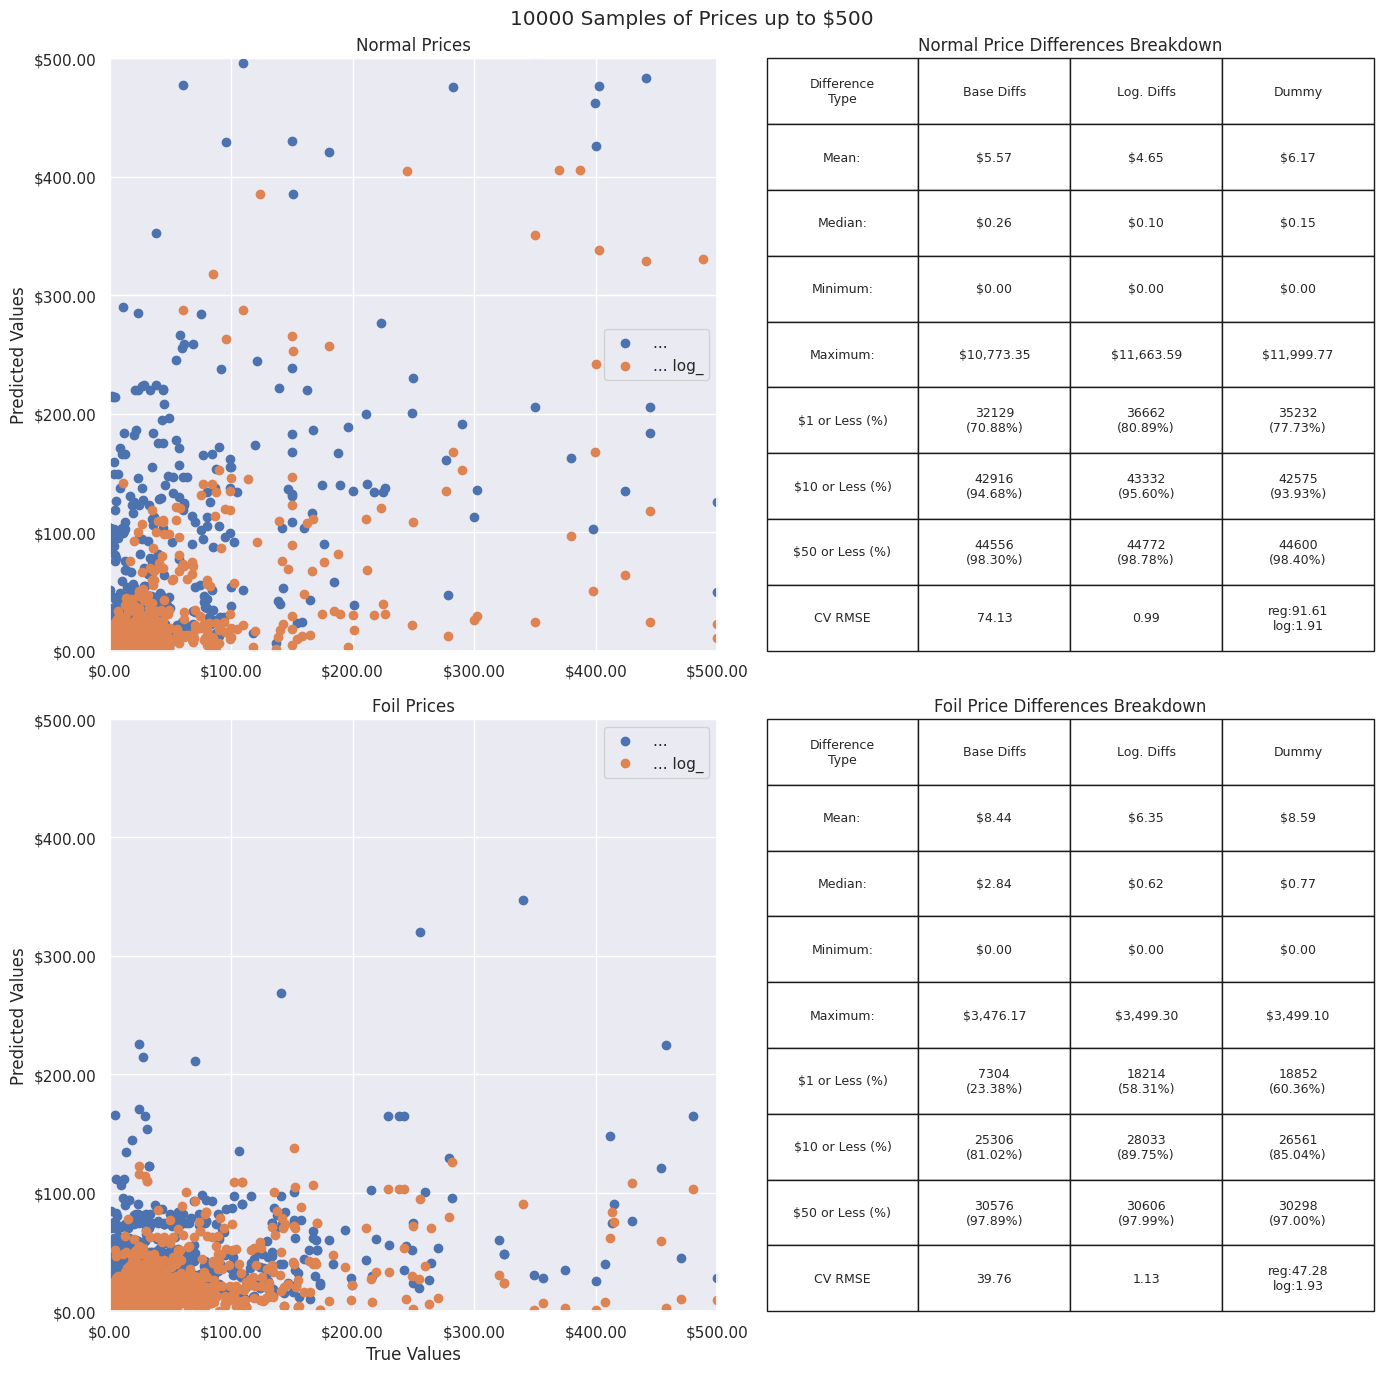

In [29]:
fig, ax = plt.subplots(2,2,figsize=(14,14),sharey=False)

_upper_limit = 500
_samps = 10000
_tb_headers = [
    'Difference\nType','Base Diffs','Log. Diffs','Dummy'
    ]
for i, (_finish,_df) in enumerate(scorers.items()):
    _df_len = len(_df)
    if _samps == None:
        _n_samples = _df_len
    else:
        _n_samples = _samps
    _sampled_df = _df.sample(_n_samples,random_state=13)
    _type = ['Normal','Foil'][i]
    ax[i][0].set(
        title=f"{_type} Prices"
    )
    X = _sampled_df['true']
    
    _table = [
            ['Mean:'],
            ['Median:'],
            ['Minimum:'],
            ['Maximum:'],
            ['$1 or Less (%)'],
            ['$10 or Less (%)'],
            ['$50 or Less (%)'],
            ['CV RMSE']
        ]
    for j, _prefix in enumerate(["","log_","dumy_"]):
        # skip doing a scatter plot if the dummy preds
        # are the active ones 
        if j<2:
            ax[i][0].scatter(
                X,_sampled_df[f"{_prefix}pred"],
                label=f"... {_prefix}"
            )
        _dif_typ = f'{_prefix}diff'
        
        # mean, median, min, and max differences per type
        _table[0].append(f"${abs(_df[_dif_typ]).mean():,.2f}")
        _table[1].append(f"${abs(_df[_dif_typ]).median():,.2f}")
        _table[2].append(f"${abs(_df[_dif_typ]).min():,.2f}")
        _table[3].append(f"${abs(_df[_dif_typ]).max():,.2f}")

        # the count and percent of cards whose
        # predictions are within 1, 10, and 50 dollars
        # of the true value
        _table[4].append(f"""{
            (_l1:=len(_df[abs(_df[_dif_typ])<=1]))
            }\n({(_l1 / _df_len)*100 :,.2f}%)""")
        _table[5].append(f"""{
            (_l10:=len(_df[abs(_df[_dif_typ])<=10]))
            }\n({(_l10 / _df_len)*100 :,.2f}%)""")
        _table[6].append(f"""{
            (_l50:=len(_df[abs(_df[_dif_typ])<=50]))
            }\n({(_l50 / _df_len)*100 :,.2f}%)""")
    _table[7].extend(
        [
            round(-models[f'{_finish}'].best_score_,2),
            round(-models[f'log_{_finish}'].best_score_,2),
            f"""reg:{round(
                mean_squared_error(
                    _df['true'],
                    _df['dumy_pred'],
                    squared=False
                ),2
            )}\nlog:{
            round(
                mean_squared_error(
                    np.log(_df['true']),
                    np.log(_df['dumy_pred']),
                    squared=False
                ),2
            )}""",
        ]
    )
    ax[i][0].set(
        ylabel='Predicted Values',
        xlim=(0,_upper_limit),
        ylim=(0,_upper_limit)
    )
    ax[i][0].xaxis.set_major_formatter('${x:,.2f}')
    ax[i][0].yaxis.set_major_formatter('${x:,.2f}')
    ax[i][0].legend()
    ax[i][1].table(
        _table,
        colLabels=_tb_headers,
        cellLoc='center',
        bbox=[0,0,1,1]
        )
    ax[i][1].grid(False)
    ax[i][1].axis('off')
    ax[i][1].set(
        title=f"{_type} Price Differences Breakdown"
    )

ax[-1][0].set(
    xlabel='True Values'
)

plt.suptitle(
    f"{_n_samples} Samples of Prices up to ${_upper_limit}"
)

plt.tight_layout()

### Analyzing the Training Results

<!-- this section is up for removal,
need to go back to the modeling step and pivot to
iterative processes -->

As it stands, our models are out-performing the Dummy
models in most areas. Though the Dummy model captures
the foil prices just a little bit better when we're
looking at it's ability to predict within $1 of a
card's actual value, capturing about 2% more than our
logged model and almost 40% more than our un-logged
model. Our non-foil dummy model also performs slightly
better than our un-logged normal model at the $1 range
but is quickly surpassed at ather ranges.

Additionally, our dummy model has the worst root mean
squared error scores for all categories.

While our results aren't incredibly close on our
training data across the board, we are seeing the model
pick up on some features. Our logged models seem to
have the best results, so we'll use that as our final
model.

Let's go ahead and review our pre-processing steps and
run our test data through to see what our model is
capable of with that.

## Running on Testing Data

Now that we have a final model selected, we need to
verify our results with our testing data.

Let's review the process that occured after our train
test split:

1. Ability Explosion, Vectorization, and Recombination
2. Type Vectorization
3. Color Identity Combination and Vectorization
4. Pseudo-Number Vectorization (Power, Toughness,
Loyalty)
5. Date Conversion
6. Column Reduction
7. Merging
8. Sticker and Conspiracy Removal
9. Foil/Non-Foil Subsetting

We'll go through this process all in one cell now and
we'll do a quick model on the end after saving off our
logged models as the best ones.

In [43]:
# ability explosion
explode_test = test.explode('abilities_list')

# ability vectorization
test_vec = cvec.transform(
        explode_test['abilities_list']
    )
test_vec = pd.DataFrame.sparse.from_spmatrix(
    test_vec
)
test_vec.columns = sorted(vocab)
test_vec['id'] = test['id']

# ability recombination/aggregation
test_pl_vec = pl.from_pandas(
        test_vec.astype(np.int32,errors='ignore')
    )
test_agg  = test_pl_vec.groupby('id').sum().to_pandas()

# type vectorization
test_type_frame = pl.from_pandas(
    test['type_line']
    ).apply(lambda x: x.split('—')[0])
test_type_df = pd.DataFrame.sparse.from_spmatrix(
    card_type_cvec.transform(
        test_type_frame
        )
)

test_type_df.columns = sorted(type_vocab)
test_type_df['id'] = test['id']

# color identity comination and vectorization
test['str_color_identity'] = \
    test['color_identity'].map(
        lambda x: ' '.join(x)
    )
test_color_id_df = pd.DataFrame.sparse.from_spmatrix(
    color_match.transform(
        test['str_color_identity']
    )
)
test_color_id_df.columns = sorted(color_vocab)
test_color_id_df['c'] = test_color_id_df.T.apply(
    lambda x: 1 if sum(x) == 0 else 0
)
test_color_id_df['id'] = test['id']

# pseudo-number vectorization
dummy_dict = {}
for _col in dummy_columns:
    dummy_vectorizer = CountVectorizer(
        token_pattern=r".*",
        stop_words=[''],
        lowercase=False,
        vocabulary=dummy_vocab[_col]
    )
    dummy_column = test[_col].T.apply(
        lambda x: '' if x == None else f'{_col}_{x}'
        )
    dummy_dict[_col] = pd.DataFrame.sparse.from_spmatrix(
        dummy_vectorizer.transform(dummy_column)#.astype(str))
    )
    dummy_vectorizer.vocabulary_
    dummy_dict[_col].columns = sorted(dummy_vocab[_col])
    dummy_dict[_col]['id'] = test['id']

test_dummies = test[['id']]
for _col in dummy_columns:
    test_dummies = test_dummies.merge(
        dummy_dict[_col],
        on='id'
    )



# date conversion
_now = pd.Timestamp.today().floor('D')
test['card_age'] = test['released_at'].apply(
    lambda x: (_now - x).days
    )

# column reduction
test_reduced = test[used_columns].copy()

# merging
test_combined = test_reduced.merge(
    test_agg,
    on='id'
).merge(
    test_type_df,
    on='id'
).merge(
    test_color_id_df,
    on='id'
).merge(
    test_dummies,
    on='id'
)
# sticker and conspiracy removal, ignore errors if
# columns don't exist
test_combined = test_combined[
    (test_combined[ 'stickers' ] == 0) &
    (test_combined['conspiracy'] == 0)
].drop(
    columns=['stickers','conspiracy'],
    errors='ignore'
    ).copy()

# foil/nonfoil subsetting
test_norm = test_combined.dropna(
    subset=['median_normal']
).drop(columns=['median_foil']
).reset_index(drop=True)

test_foil = test_combined.dropna(
    subset=['median_foil']
).drop(columns=['median_normal']
).reset_index(drop=True)

test_norm_prices = test_norm['median_normal']
test_foil_prices = test_foil['median_foil']

# vectorizers are from before and have already been
# fitted


In [45]:
# selecting best models
norm_best_model = models['log_norm'].best_estimator_
foil_best_model = models['log_foil'].best_estimator_

## Testing the Testing Data

Now that we have our desting data prepared and our
models selected, it's time to run our models against
the testing data and review our model performance.

In [48]:
np.exp(test_norm_preds)

array([1.81047479, 0.40710091, 0.2844865 , ..., 0.04808932, 1.31687805,
       0.45212581])

In [57]:
test_scorers['norm']['pred'].max()

6.025653362247361

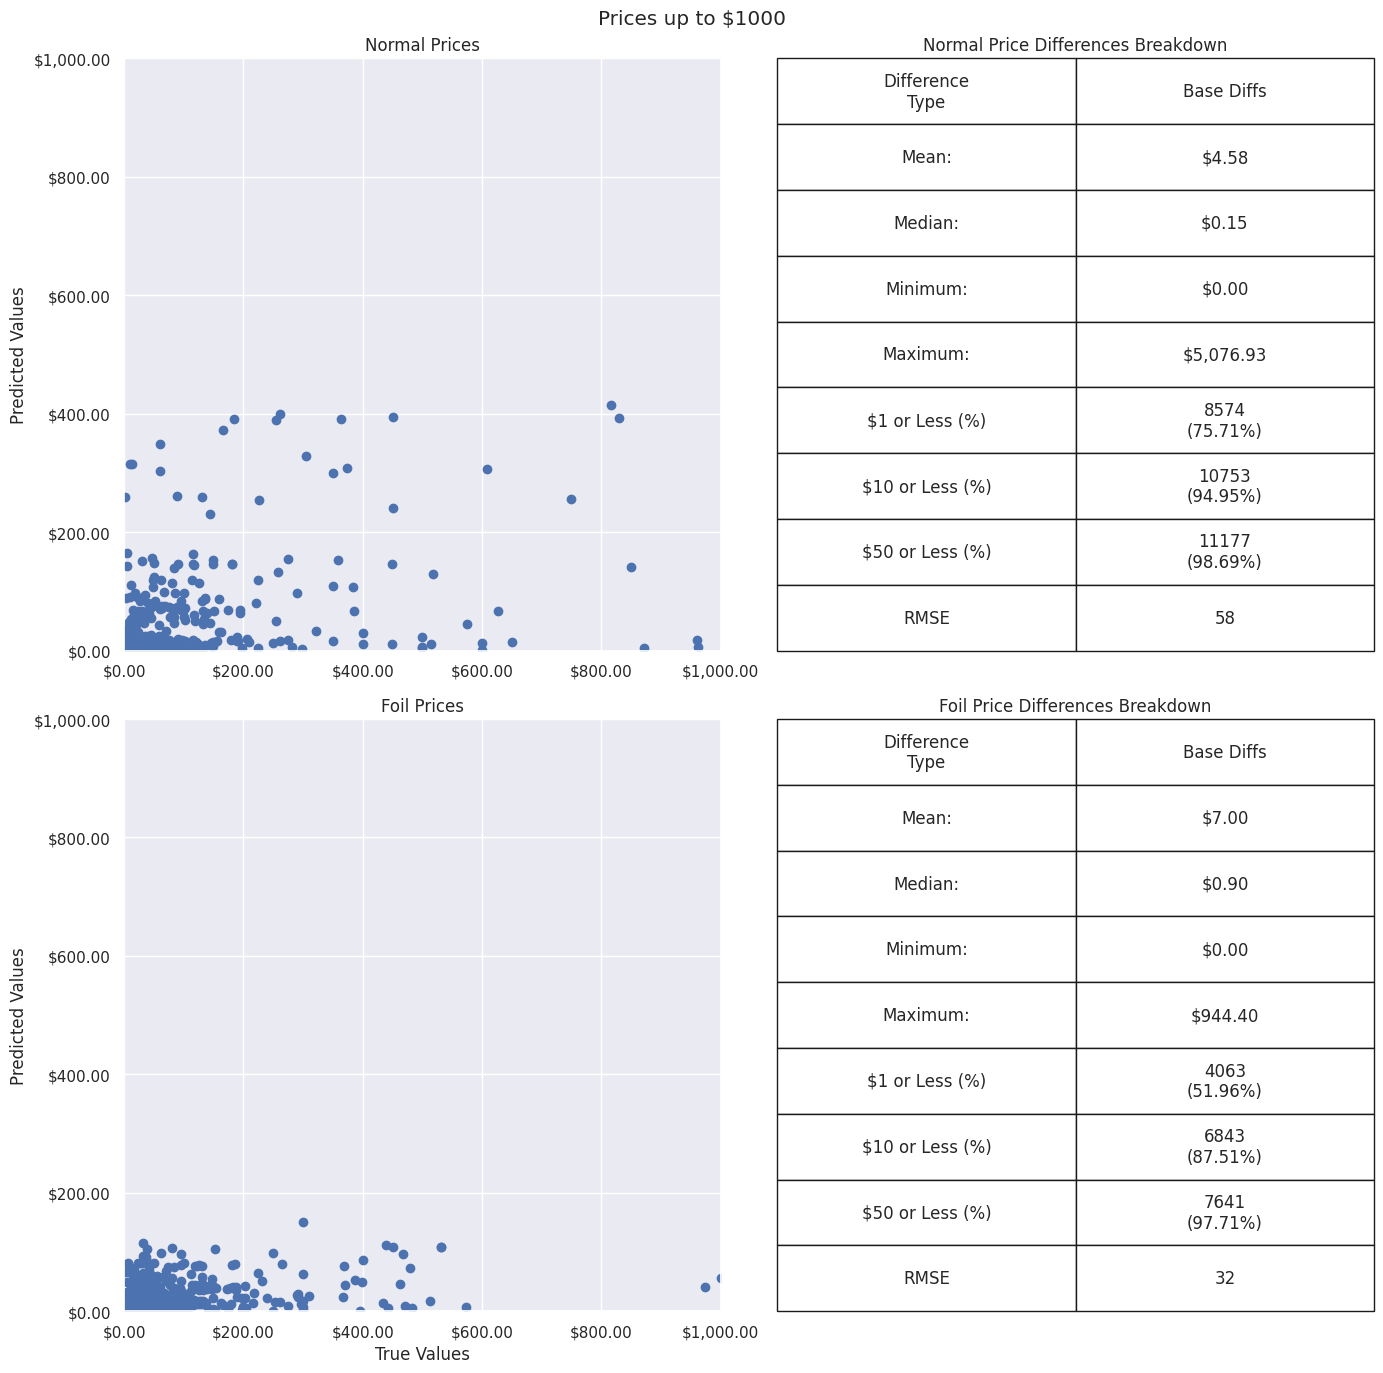

In [66]:
# generating a test version of the scorers from earlier
test_scorers = {}

_upper_limit = 1000

test_norm_preds = np.exp(norm_best_model.predict(
    test_norm.drop(columns=['id','median_normal']).to_numpy()
    ))
test_foil_preds = np.exp(foil_best_model.predict(
    test_foil.drop(columns=['id','median_foil']).to_numpy()
    ))

test_scorers['norm'] = pd.DataFrame(
    {
        'id': test_norm['id'],
        'pred': test_norm_preds,
        'true': test_norm_prices,
        'diff': test_norm_preds - test_norm_prices
    }
)

test_scorers['foil'] = pd.DataFrame(
    {
        'id': test_foil['id'],
        'pred': test_foil_preds,
        'true': test_foil_prices,
        'diff': test_foil_preds - test_foil_prices
    }
)

fig, ax = plt.subplots(2,2,figsize=(14,14),sharey=False)

for i, (_finish,_df) in enumerate(test_scorers.items()):
    _type = ['Normal','Foil'][i]
    _df_len = len(_df)
    ax[i][0].set(
        title=f"{_type} Prices"
    )
    X = _df['true']
    
    _table = [
            ['Mean:'],
            ['Median:'],
            ['Minimum:'],
            ['Maximum:'],
            ['$1 or Less (%)'],
            ['$10 or Less (%)'],
            ['$50 or Less (%)'],
            ['RMSE']
        ]
    ax[i][0].scatter(
        X,_df['pred']
    )
    _table[0].append(f"${abs(_df['diff']).mean():,.2f}")
    _table[1].append(f"${abs(_df['diff']).median():,.2f}")
    _table[2].append(f"${abs(_df['diff']).min():,.2f}")
    _table[3].append(f"${abs(_df['diff']).max():,.2f}")
    _table[4].append(f"""{
        (_l1:=len(_df[abs(_df['diff'])<=1]))
        }\n({(_l1 / _df_len)*100 :,.2f}%)""")
    _table[5].append(f"""{
        (_l10:=len(_df[abs(_df['diff'])<=10]))
        }\n({(_l10 / _df_len)*100 :,.2f}%)""")
    _table[6].append(f"""{
        (_l50:=len(_df[abs(_df['diff'])<=50]))
        }\n({(_l50 / _df_len)*100 :,.2f}%)""")
    _table[7].extend(
        [
            round(mean_squared_error(
                X,_df['pred'],
                squared=False
            )),
        ]
    )
    
    ax[i][0].set(
        ylabel='Predicted Values',
        xlim=(0,_upper_limit),
        ylim=(0,_upper_limit)
    )
    ax[i][0].xaxis.set_major_formatter('${x:,.2f}')
    ax[i][0].yaxis.set_major_formatter('${x:,.2f}')
    ax[i][1].table(
        _table,
        colLabels=_tb_headers,
        cellLoc='center',
        bbox=[0,0,1,1]
        )
    ax[i][1].grid(False)
    ax[i][1].axis('off')
    ax[i][1].set(
        title=f"{_type} Price Differences Breakdown"
    )

ax[-1][0].set(
    xlabel='True Values'
)

plt.suptitle(
    f"Prices up to ${_upper_limit}"
)

plt.tight_layout()